# Train nw2vec with the original VGAE architecture for Cora embeddings + a kernel for the scalar product decoding + an intermediate layer in decoding

In [1]:
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import contextlib

import numpy as np
import keras
from keras_tqdm import TQDMNotebookCallback as TQDMCallback

from nw2vec import layers
from nw2vec import ae
from nw2vec import utils
from nw2vec import batching
import settings

from gae.input_data import load_data
from gae.preprocessing import sparse_to_tuple, mask_test_edges

Using TensorFlow backend.


In [2]:
@contextlib.contextmanager
def gae_directory():
    working_directory = os.path.abspath(os.curdir)
    try:
        # Move to the GAE directory
        os.chdir('../../gae')
        yield
    finally:
        # Move back
        os.chdir(working_directory)

In [3]:
# Load data
with gae_directory():
    adj, features = load_data('citeseer')
    features = features.toarray()

#adj_train = mask_test_edges(adj)[0]
adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
assert adj_train.diagonal().sum() == 0

In [4]:
n_ξ_samples = 1
n_nodes = adj_train.shape[0]
dim_data, dim_l1, dim_ξ_adj, dim_ξ_v = features.shape[1], 32, 16, 16
overlap = 0
dims = (dim_data, dim_l1, dim_ξ_adj, dim_ξ_v)
loss_weights = {
    'q_mulogS_flat': 1e-2 * 1.0 / (dim_ξ_adj - overlap + dim_ξ_v),
    'p_adj': 1.0 / (n_nodes * np.log(2)),
    'p_v': 1.0 / (features.shape[1] * np.log(2)),
}

# Actual VAE
q_model, q_codecs = ae.build_q(dims, overlap=overlap,
                               fullbatcher=batching.fullbatches, minibatcher=batching.pq_batches)
p_builder = ae.build_p_builder(dims,
                               feature_codec='SigmoidBernoulli',
                               embedding_slices=[slice(dim_ξ_adj),
                                                 slice(dim_ξ_adj - overlap, dim_ξ_adj - overlap + dim_ξ_v)],
                               with_l1=True, share_l1=False)
vae, vae_codecs = ae.build_vae(
    (q_model, q_codecs), p_builder,
    n_ξ_samples,
    loss_weights=loss_weights
)

In [5]:
def target_func(batch_adj, required_nodes, final_nodes):
    return [
        np.zeros(1), # ignored
        utils.expand_dims_tile(utils.expand_dims_tile(batch_adj + np.eye(batch_adj.shape[0]), 0, n_ξ_samples), 0, 1),
        utils.expand_dims_tile(features[final_nodes], 1, n_ξ_samples),
    ]

In [6]:
n_epochs = 200

history = vae.fit_fullbatches(batcher_kws={'adj': adj_train, 'features': features, 'target_func': target_func},
                              epochs=n_epochs,
                              verbose=0, callbacks=[TQDMCallback(show_inner=False)])

/home/slerique/anaconda3/envs/base36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [7]:
history = {'history': history.history}

## Results

In [8]:
import matplotlib.pyplot as plt

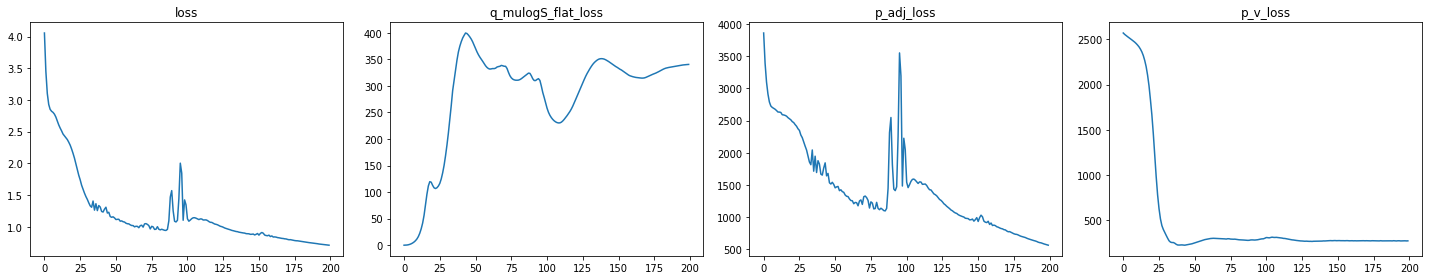

In [9]:
fig, axes = plt.subplots(1, len(history['history']), figsize=(len(history['history']) * 5, 4))
for i, (title, values) in enumerate(history['history'].items()):
    axes[i].plot(np.array(values))
    axes[i].set_title(title)
fig.tight_layout()

## Precision

In [10]:
import scipy
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from keras import backend as K

In [11]:
def get_roc_score(edges_pos, edges_neg, adj_pred):
    # Predict on test set of edges
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(adj_pred[e[0], e[1]])
        pos.append(adj[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(adj_pred[e[0], e[1]])
        neg.append(adj[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

In [12]:
q_preds, adj_preds, v_preds = zip(*[vae.predict_fullbatch(adj=adj_train, features=features) for _ in range(10)])

q_preds = np.array(q_preds)
adj_preds = np.array(adj_preds)

q_pred = q_preds.mean(0)
adj_pred = scipy.special.expit(adj_preds[:, 0, :, :, :]).mean(1).mean(0)

In [13]:
get_roc_score(test_edges, test_edges_false, adj_pred)

(0.869629271827074, 0.8728135963143449)

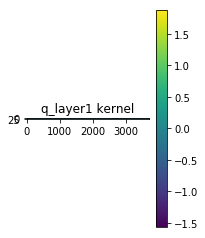

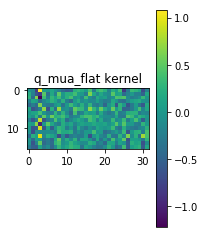

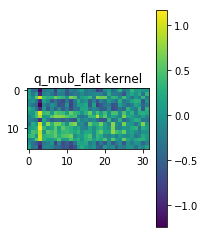

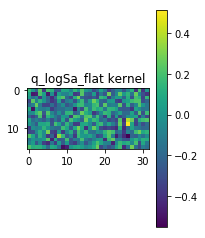

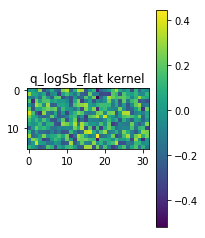

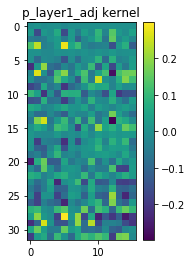

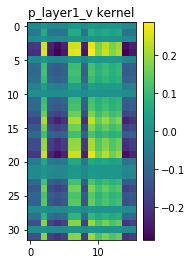

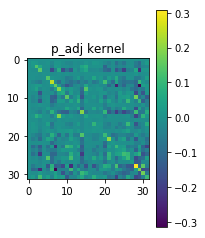

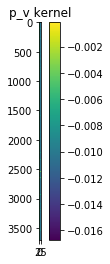

In [14]:
for layer in vae.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
        if hasattr(layer, 'bias') and layer.bias is not None:
            im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
            ax2.set_title('{} bias'.format(layer.name))
            plt.colorbar(im2, ax=ax2)
        else:
            ax2.set_visible(False)

## Plot the embeddings

In [ ]:
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import scipy
import scipy.sparse as sp
import seaborn as sb

from sklearn.manifold import MDS

In [ ]:
# Downscale the embeddings
mds = MDS(n_jobs=-2, )
mds.fit(q_pred[:, :dims[-1]].astype(np.float64))

In [ ]:
# Load the ground truth labels

def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

with gae_directory():
    ty = pickle.load(open("data/ind.cora.ty", 'rb'), encoding='latin1')
    ally = pickle.load(open("data/ind.cora.ally", 'rb'), encoding='latin1')
    test_idx_reorder = parse_index_file("data/ind.cora.test.index")
test_idx_range = np.sort(test_idx_reorder)

labels = sp.vstack((ally, ty)).toarray()
labels[test_idx_reorder, :] = labels[test_idx_range, :]

In [ ]:
# Turn labels into colors
palette = sb.color_palette(n_colors=labels.shape[1])
colors = np.array(palette)[np.argmax(labels, axis=1)]

In [ ]:
# Plot the downscaled embeddings and the links
fig, ax = plt.subplots(figsize=(15, 15))
edges = np.array([[mds.embedding_[i], mds.embedding_[j]] for (i, j) in sparse_to_tuple(sp.triu(adj))[0]])
edges = edges.transpose([2, 1, 0])
ax.plot(edges[0], edges[1], color='lightgrey', zorder=1)
ax.scatter(mds.embedding_[:, 0], mds.embedding_[:, 1], c=colors, zorder=2)